In [33]:
import numpy as np
import matplotlib.pyplot as plt
# import database_manager as dbm
import pandas as pd
from scipy.fft import rfft
import numpy.random as rand
import ArtificialData
import importlib
importlib.reload(ArtificialData)


<module 'ArtificialData' from '/Users/cassiopeia/Desktop/ASTR5470/Fourier-Transform-Light-Periodicy/ArtificialData.py'>

Artificial Data formation and Alteration/ Pulse Profile 

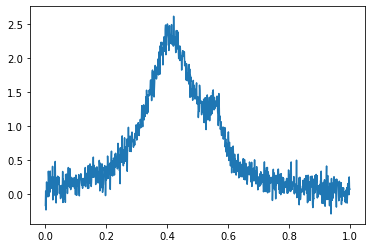

In [50]:
# Generates  
phi = np.linspace(0, 1, 1024)
pulses, locs = ArtificialData.generate_dummy(1,1024)
# (number of artificial pulses, number of phase bins )
np.savez('TestData.npz', *[pulses, locs], **{'pulses' : pulses, 'locs': locs})

# Plotting the Data for a general view
pulse, locs, gammas, amps = ArtificialData.generate(100, 1024)
plt.plot(phi, pulse[0])
# x-axis - rotational phase 
# y-axis - radio photons 

In [66]:
from scipy.signal import unit_impulse as delta
# delta function returns array where all the entries are 0 except for 1 
print(delta(5))

[1. 0. 0. 0. 0.]


Main Code 

In [53]:
def shah(spacing, n):
    shah_list = []
    for i in range(n):
        shah_list.extend(delta(spacing))
    return np.array(shah_list)

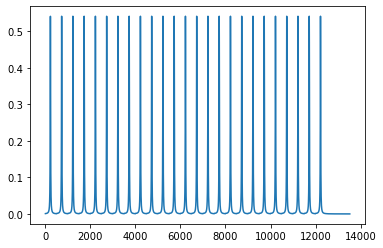

In [63]:
pulse_train = np.convolve(pulses[0], shah(500, 25))
plt.plot(pulse_train)

(1.0, 250.0)

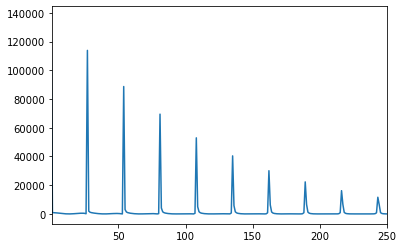

In [65]:
trainFFT = abs(np.fft.rfft(pulse_train))**2
#
plt.plot(trainFFT)
plt.xlim(1, 250)
# x axis needs frq resolution which is 1/total length of bins
# arbitrary power 

In [47]:
# def gaussian(x, mu, sig):
#     return np.exp(-0.5*((x - mu)/sig)**2)/(sig*np.sqrt(2*np.pi))

# phi_bins = 1024
# pulse = gaussian(np.linspace(0, 1, phi_bins), 0.5, 0.05) + 0.15*gaussian(np.linspace(0, 1, phi_bins), 0.6, 0.01)
# pulse /= max(pulse)

# plt.plot(pulse)
# plt.xlabel(r'$\phi$')
# plt.ylabel('Normalized Stokes Intensity')
# plt.title('Sample Gaussian Pulse and Sub-Pulse')

#  Example from Git hub 
#  link to the github reference:
#  https://github.com/pavelkulich/SignalAnalysis/blob/36a35c6a9e37a9ce65d6bb1e6098652671018a90/spectrum.py  

# def dft(x):
#     """
#     Compute the discrete Fourier Transform of the 1D array x
#     :param x: (array)
#     """

#     N = len(x)
#     n = np.arange(N)
#     k = n.reshape((N, 1))
#     e = np.exp(-2j * np.pi * k * n / N)
#     return np.dot(e, x)


# def plot_frequency(x, y, N):
#     plt.plot(x[0:N // 2], np.abs(y)[0:N // 2] / N)
#     plt.xlabel('frequency [Hz]')
#     plt.ylabel('amplitude [mm]')
#     plt.xscale('log')
#     plt.grid(True, which='major')
#     plt.grid(True, which='minor')
#     plt.show()


# def plot_wavelength(x, y, N):
#     plt.bar(N / 4 * x[2:N // 2] ** (-1), np.abs(y)[2:N // 2] / N)
#     plt.xlabel('wavelength [m]')
#     plt.ylabel('amplitude [mm]')
#     plt.xscale('log')
#     plt.grid(True, which='major')
#     plt.grid(True, which='minor')
#     plt.savefig('plots/dft.png')
#     plt.show()


# def import_file(directory, file):
#     path = f'{directory}/{file}'
#     data_frame = pd.read_fwf(path).dropna()
#     return data_frame


# def main():
#     # plot = ('MV_2015_03_15', 106.000, 107.000, 'VK_D2')
#     # database = dbm.DbManager('signal.sqlite3')
#     # data = database.fetch_data(plot[0], plot[1], plot[2], plot[3])

#     # x = [row[0] for row in data]
#     # y = [row[1] for row in data]
#     # amp = dft(y)
#     data = import_file("data", "2015_03_15.txt")
#     x = data['_KM.M____'][0:4000]
#     y = data['SL_D1'][0:4000]
#     N = x.size
#     amp = np.fft.fft(y)
#     T = x[1] - x[0]
#     # N = len(y)
#     f = np.linspace(0, 1 / T, N)
#     # plt.plot(y)
#     # plt.grid(True, which='major')
#     # plt.grid(True, which='minor')
#     # plt.show()
#     plot_wavelength(f, amp, N)


# main()

In [23]:
#  Full code with discription  Reyn


def harmonics(prof, f_true, df):
    
    """This function calculates the array of frequency-domain harmonics for a given pulse profile.

    Inputs:
    _______
            prof (ndarray): pulse phase profile
            f_true (float): true rotational frequency in Hz
            df (float)    : frequency bin width in target spectrum

    Returns:
    ________
            harmonics (ndarray) : Fourier-transformed harmonics of the profile convolved with
                                    [cycles] number of Delta functions
    """
    #currently we are calculating the first 10 harmonics in the 2 bins on either side of the true value (2 + 2 = 4)
    harmonics = np.zeros((40))
    bins = np.zeros((40)).astype(int)

    #take the fft of the pulse
    prof_fft = rfft(prof)
    
    #now evaluate sinc-modified power at each of the first 10 harmonics
    for i in range(1, 11):
        f_harm = i*f_true
        bin_true = f_harm/df
        bin_below = np.floor(bin_true)
        bin_above = np.ceil(bin_true)

        #use 2 bins on either side
        current_bins = np.array([bin_below - 1, bin_below, bin_above, bin_above + 1])
        bins[(i - 1)*4:(i - 1)*4+4] = current_bins
        amplitude = prof_fft[i]*sinc(np.pi*(bin_true - current_bins))
        harmonics[(i - 1)*4:(i - 1)*4+4] = np.abs(amplitude)**2

    return bins, harmonics

In [24]:


# continuation plotting harmonics 
nbins = 300000

bins, harm = harmonics(pulses, true_freq, df)
freq = np.zeros(nbins)
freq[bins] = harm
plt.plot(np.arange(0, nbins, 1)*df, freq)
plt.xlabel('Rotational Frequency (Hz)')
plt.ylabel('Some Power')
plt.title('Sinc-Approximated Harmonics of our Pulse')


NameError: name 'pulses' is not defined